# Feature Importance & Ablation Study: Wine Quality Dataset

**Research Question:** "Which features matter and why? An ablation study on the Wine Quality dataset."

**Authoren:** Katrin Nguyen & Nico Loss

## 1. Setup & Imports <a id='setup'></a>

In [39]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score
)
from sklearn.base import clone

# Feature selection methods
from sklearn.feature_selection import (
    mutual_info_classif,
    f_classif
)
from sklearn.inspection import permutation_importance

# Report generation
from ydata_profiling import ProfileReport

# For data fetching
from ucimlrepo import fetch_ucirepo

from scipy import stats

warnings.filterwarnings('ignore')

# Matplotlib inline for Jupyter Notebooks
%matplotlib inline

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration
TEST_SIZE = 0.20
CV_FOLDS = 5

Path("Reports").mkdir(exist_ok=True)
Path("figures").mkdir(exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful")

✓ All imports successful


## 2. Data Loading & Exploration <a id='data-loading'></a>

### 2.1 Load Dataset
Link: https://archive.ics.uci.edu/dataset/186/wine+quality

In [40]:
# Fetch dataset from UCI repository
print("Fetching Wine Quality dataset from UCI repository...")
url_weisswein = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
df = pd.read_csv(url_weisswein, sep=';')

print(f"\n✓ Dataset loaded successfully")
print(f"  - Shape: {df.shape}")
print(f"  - Samples: {len(df)}")

Fetching Wine Quality dataset from UCI repository...

✓ Dataset loaded successfully
  - Shape: (4898, 12)
  - Samples: 4898


## 3. Data Preprocessing <a id='preprocessing'></a>

### 3.1 Missing Values Check

In [41]:
print("Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values")
print("\n✓ Dataset is clean - no missing values")

Missing Values:
No missing values

✓ Dataset is clean - no missing values


### 3.2 Train/Validation/Test Split

In [42]:
print("\n" + "="*50)
print("TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)")
print("="*50)

# First split: separate train set (70%)
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)

# Second split: separate test (15%) and validation (15%)
df_test, df_val = train_test_split(df_temp, test_size=0.5, random_state=42)

print(f"Training set (raw): {len(df_train)} samples")
print(f"Validation set (raw): {len(df_val)} samples")
print(f"Test set (raw): {len(df_test)} samples")


TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)
Training set (raw): 3428 samples
Validation set (raw): 735 samples
Test set (raw): 735 samples


### 3.3 Report Generation

In [43]:
profile = ProfileReport(df_train, title="Wine Quality Dataset Report", explorative=True)
profile.to_file("Reports/wine_quality_ydata_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 49.08it/s]


### 3.4 Outlier-Behandlung

In [44]:
print("\n" + "="*60)
print("OUTLIER HANDLING")
print("="*60)

# 1. Definieren der Features, die geprüft werden sollen
TARGET_COL = 'quality'
feature_names = [col for col in df_train.columns if col != TARGET_COL]
factor = 3.0

print(f"Berechne Outlier-Grenzen (IQR-Faktor={factor}) aus df_train...")

# 2. Outlier-Grenzen aus den Trainingsdaten berechnen
bounds = {}
for feature in feature_names:
    Q1 = df_train[feature].quantile(0.25)
    Q3 = df_train[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    bounds[feature] = (lower_bound, upper_bound)

# 3. Funktion, um Zeilen basierend auf den gelernten Grenzen zu entfernen
def remove_outliers_with_bounds(df, bounds_dict):
    df_clean = df.copy()
    # Maske ist initial True für alle Zeilen
    mask = pd.Series(True, index=df_clean.index)

    # Filtere alle Features: Eine Zeile wird entfernt, wenn sie *bei irgendeinem* Feature
    # außerhalb der Grenzen liegt.
    for feature, (lower, upper) in bounds_dict.items():
        # Behalte Zeilen, die INNERHALB der Grenzen liegen (mask & (Bedingung))
        mask = mask & (df_clean[feature] >= lower) & (df_clean[feature] <= upper)


    removed_count = len(df_clean) - mask.sum()
    return df_clean[mask], removed_count

# 4. Wende die gleichen Grenzen auf alle drei Datensätze an
print("\nWende Grenzen auf df_train, df_val und df_test an...")

len_train_orig = len(df_train)
df_train, removed_train = remove_outliers_with_bounds(df_train, bounds)
print(f"  Trainingsset:   {len_train_orig} -> {len(df_train)} (Entfernt: {removed_train})")

len_val_orig = len(df_val)
df_val, removed_val = remove_outliers_with_bounds(df_val, bounds)
print(f"  Validierungsset: {len_val_orig} -> {len(df_val)} (Entfernt: {removed_val})")

len_test_orig = len(df_test)
df_test, removed_test = remove_outliers_with_bounds(df_test, bounds)
print(f"  Testset:       {len_test_orig} -> {len(df_test)} (Entfernt: {removed_test})")

total_orig = len_train_orig + len_val_orig + len_test_orig
total_removed = removed_train + removed_val + removed_test

print(f"\nInsgesamt entfernt: {total_removed} Samples ({(total_removed / total_orig * 100):.2f}%)")


OUTLIER HANDLING
Berechne Outlier-Grenzen (IQR-Faktor=3.0) aus df_train...

Wende Grenzen auf df_train, df_val und df_test an...
  Trainingsset:   3428 -> 3269 (Entfernt: 159)
  Validierungsset: 735 -> 695 (Entfernt: 40)
  Testset:       735 -> 695 (Entfernt: 40)

Insgesamt entfernt: 239 Samples (4.88%)


### 3.5 Prepare Feature and Target

In [45]:
# Bin 0-4 -> schlecht (deckt 3 und 4 ab)
# Bin 5-6 -> mittel (deckt 5 und 6 ab)
# Bin 7-10 -> gut (deckt 7 und 8 ab)
bins = [0, 4, 6, 10]
labels = ['schlecht', 'mittel', 'gut']

df_train['quality_simple'] = pd.cut(df_train['quality'], bins=bins, labels=labels, right=True)
df_val['quality_simple'] = pd.cut(df_val['quality'], bins=bins, labels=labels, right=True)
df_test['quality_simple'] = pd.cut(df_test['quality'], bins=bins, labels=labels, right=True)

In [46]:
print("\n" + "="*50)
print("FEATURE AND TARGET PREPARATION")
print("="*50)

# Zielvariable (Target)
TARGET_COL = ['quality', 'quality_simple']

# Extract features and targets
X_train = df_train.drop(['quality', 'quality_simple'], axis=1)
y_train = df_train['quality_simple']

X_val = df_val.drop(['quality', 'quality_simple'], axis=1)
y_val = df_val['quality_simple']

X_test = df_test.drop(['quality', 'quality_simple'], axis=1)
y_test = df_test['quality_simple']

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


FEATURE AND TARGET PREPARATION
X_train shape: (3269, 11)
X_val shape: (695, 11)
X_test shape: (695, 11)


### 3.6 Feature Scaling

In [47]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Feature Scaling Complete (StandardScaler)")
print(f"  Train mean: {X_train_scaled.mean().mean():.6f}")
print(f"  Train std:  {X_train_scaled.std().mean():.6f}")

Feature Scaling Complete (StandardScaler)
  Train mean: 0.000000
  Train std:  1.000153


## 4.0 Explorative Data Analysis

In [48]:
print("First 5 rows:")
display(df_train.head())

print("\nDataset Statistics:")
display(df_train.describe())

print("\nData Types and Missing Values:")
info_df = pd.DataFrame({
    'Column': df_train.columns,
    'Type': df_train.dtypes,
    'Non-Null': df_train.count(),
    'Null': df_train.isnull().sum(),
    'Null %': (df_train.isnull().sum() / len(df_train) * 100).round(2)
})
display(info_df)

First 5 rows:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_simple
736,6.6,0.25,0.30,14.40,0.052,40.0,183.0,0.99800,3.02,0.50,9.1,6,mittel
1620,7.8,0.26,0.49,3.20,0.027,28.0,87.0,0.99190,3.03,0.32,11.3,7,gut
336,6.3,0.23,0.33,1.50,0.036,15.0,105.0,0.99100,3.32,0.42,11.2,6,mittel
2302,6.0,0.26,0.18,7.00,0.055,50.0,194.0,0.99591,3.21,0.43,9.0,5,mittel
2673,7.9,0.37,0.31,2.85,0.037,5.0,24.0,0.99110,3.19,0.36,11.9,6,mittel



Dataset Statistics:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3269.000000,3269.000000,3269.000000,3269.000000,3269.000000,3269.000000,3269.000000,3269.000000,3269.000000,3269.000000,3269.000000,3269.000000
mean,6.851392,0.275301,0.325482,6.408565,0.042810,35.091159,137.576935,0.993999,3.192291,0.488642,10.534309,5.892016
std,0.833239,0.093123,0.103628,5.021604,0.010892,16.395974,41.627126,0.002922,0.149355,0.112200,1.226245,0.889019
min,3.800000,0.080000,0.000000,0.600000,0.009000,3.000000,10.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.035000,23.000000,108.000000,0.991700,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.310000,5.200000,0.043000,34.000000,134.000000,0.993680,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.380000,9.900000,0.050000,46.000000,167.000000,0.996100,3.290000,0.550000,11.400000,6.000000
max,10.300000,0.685000,0.710000,26.050000,0.092000,112.000000,259.000000,1.002950,3.820000,0.960000,14.200000,9.000000



Data Types and Missing Values:


,Column,Type,Non-Null,Null,Null %
fixed acidity,fixed acidity,float64,3269,0,0.0
volatile acidity,volatile acidity,float64,3269,0,0.0
citric acid,citric acid,float64,3269,0,0.0
residual sugar,residual sugar,float64,3269,0,0.0
chlorides,chlorides,float64,3269,0,0.0
free sulfur dioxide,free sulfur dioxide,float64,3269,0,0.0
total sulfur dioxide,total sulfur dioxide,float64,3269,0,0.0
density,density,float64,3269,0,0.0
pH,pH,float64,3269,0,0.0
sulphates,sulphates,float64,3269,0,0.0


### 4.3 Correlation Analysis

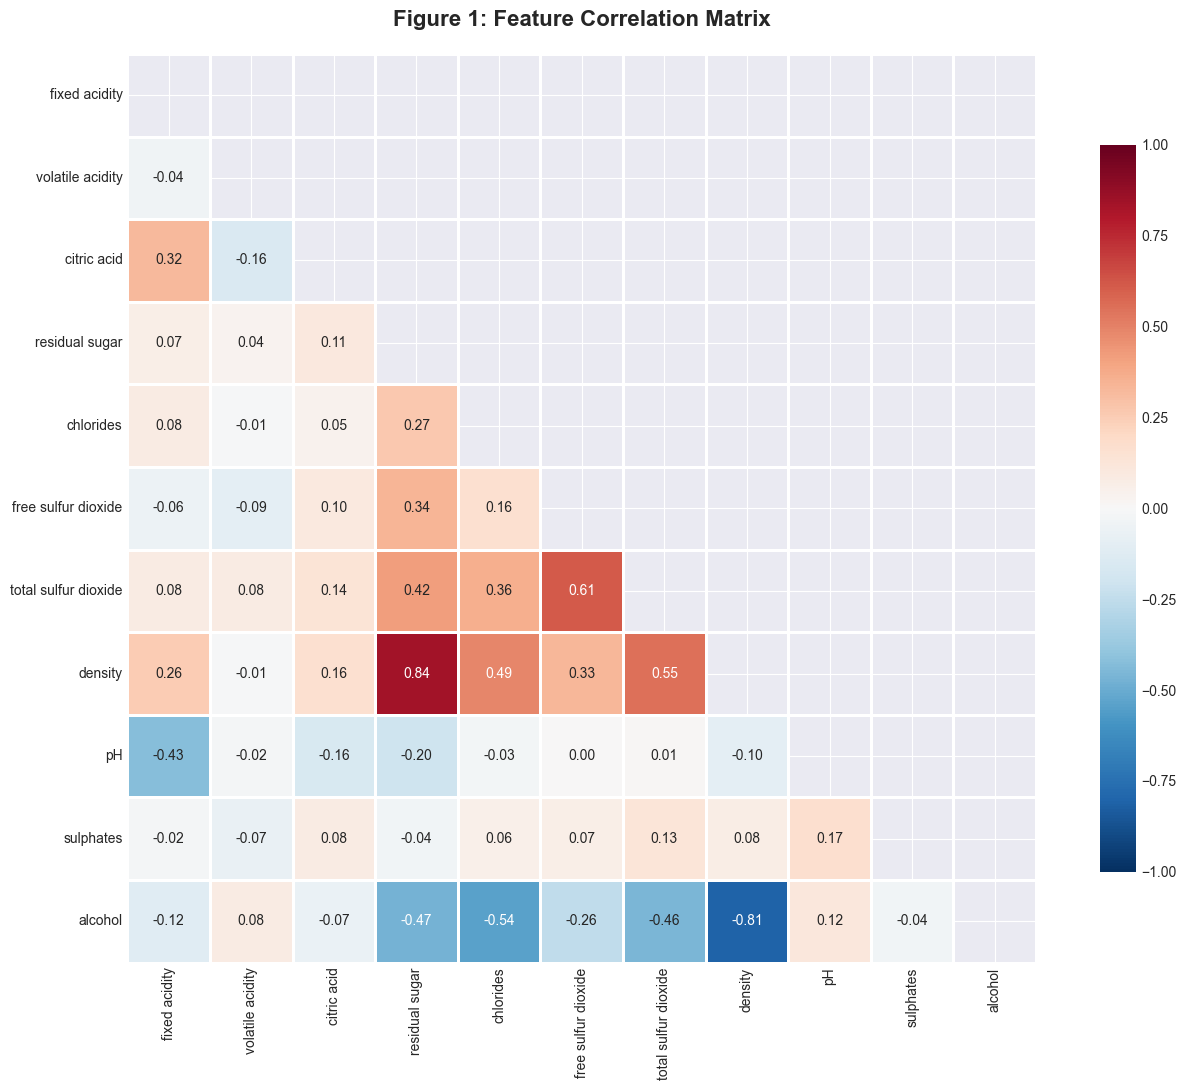

In [49]:
correlation_matrix = X_train.corr()

plt.figure(figsize=(14, 11))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Figure 1: Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('figures/figure1_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Baseline Model

### 5.1 Train and Evaluate Baseline Model

In [50]:
print("Aktuelle Verteilung von y_train:")
print(y_train.value_counts())

Aktuelle Verteilung von y_train:
quality_simple
mittel      2426
gut          726
schlecht     117
Name: count, dtype: int64


In [51]:
sampling_strategy = {
    'schlecht': 721,
}

sampler = SMOTEENN(random_state=RANDOM_STATE,
                   sampling_strategy=sampling_strategy,
                   smote=SMOTE(random_state=RANDOM_STATE, k_neighbors=3))

param_grid = {
    'rf__max_depth': [5, 6, 7],
    'rf__min_samples_split': [10, 15, 20],
    'rf__min_samples_leaf': [8, 10, 12],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__n_estimators': [80, 100, 120]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Erstellen der imbalanced-learn Pipeline
pipe = ImbPipeline([
    ('sampler', sampler),
    ('rf', rf)
])

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 3. Modell trainieren
grid_search.fit(X_train_scaled, y_train)

print(f"\nBeste Parameter nach GridSearchCV: {grid_search.best_params_}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits

Beste Parameter nach GridSearchCV: {'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 10, 'rf__n_estimators': 80}


In [52]:
baseline_model = grid_search.best_estimator_

# Predictions
y_train_pred = baseline_model.predict(X_train_scaled)
y_val_pred = baseline_model.predict(X_val_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

print("Führe Baseline CV mit f1_weighted durch...")
cv_scores_f1 = cross_val_score(baseline_model, X_train_scaled, y_train,
                               cv=CV_FOLDS, scoring='f1_weighted', n_jobs=-1)

# Metrics
baseline_metrics = {
    'Training Accuracy': accuracy_score(y_train, y_train_pred),
    'Validation Accuracy': accuracy_score(y_val, y_val_pred),
    'Test Accuracy': accuracy_score(y_test, y_test_pred),

    'CV Mean F1': cv_scores_f1.mean(),
    'CV Std F1': cv_scores_f1.std(),

    'Validation F1': f1_score(y_val, y_val_pred, average='weighted'),
    'Test F1': f1_score(y_test, y_test_pred, average='weighted'),
    'Validation Precision': precision_score(y_val, y_val_pred, average='weighted', zero_division=0),
    'Validation Recall': recall_score(y_val, y_val_pred, average='weighted'),
    'Test Precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
    'Test Recall': recall_score(y_test, y_test_pred, average='weighted')
}

print("\n" + "="*70)
print("TABLE 2: BASELINE PERFORMANCE (REGULARIZED MODEL)")
print("="*70)
for metric, value in baseline_metrics.items():
    print(f"{metric:25s}: {value:.4f}")

# Check overfitting
train_val_gap = baseline_metrics['Training Accuracy'] - baseline_metrics['Validation Accuracy']
print(f"\n{'='*70}")
print(f"OVERFITTING CHECK")
print(f"{'='*70}")
print(f"Train-Validation Gap: {train_val_gap:.4f} ({train_val_gap*100:.2f}%)")

if train_val_gap < 0.05:
    print("✓✓ EXCELLENT: Gap < 5% - No overfitting!")
elif train_val_gap < 0.10:
    print("✓ GOOD: Gap < 10% - Acceptable generalization")
elif train_val_gap < 0.15:
    print("⚠ WARNING: Gap 10-15% - Slight overfitting")
else:
    print("❌ PROBLEM: Gap > 15% - Significant overfitting")

# Save
pd.DataFrame([baseline_metrics]).to_csv('figures/table2_baseline_performance.csv', index=False, sep=";")
print("\n✓ Saved to figures/table2_baseline_performance.csv")

Führe Baseline CV mit f1_weighted durch...

TABLE 2: BASELINE PERFORMANCE (REGULARIZED MODEL)
Training Accuracy        : 0.6084
Validation Accuracy      : 0.5568
Test Accuracy            : 0.5914
CV Mean F1               : 0.6074
CV Std F1                : 0.0233
Validation F1            : 0.5940
Test F1                  : 0.6192
Validation Precision     : 0.7884
Validation Recall        : 0.5568
Test Precision           : 0.7737
Test Recall              : 0.5914

OVERFITTING CHECK
Train-Validation Gap: 0.0516 (5.16%)
✓ GOOD: Gap < 10% - Acceptable generalization

✓ Saved to figures/table2_baseline_performance.csv


### 5.2 Detailed Cross-Validation Analyse

In [53]:
print("="*80)
print("DETAILLIERTE CROSS-VALIDATION ANALYSE")
print("="*80)

# Define scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted'
}

# Perform cross-validation with multiple metrics
print(f"\nDurchführung der {CV_FOLDS}-Fold Cross-Validation...\n")
cv_results = cross_validate(
    baseline_model,
    X_train_scaled,
    y_train,
    cv=CV_FOLDS,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# Create DataFrame for better visualization
cv_results_df = pd.DataFrame({
    'Fold': range(1, CV_FOLDS + 1),
    'Train Accuracy': cv_results['train_accuracy'],
    'Test Accuracy': cv_results['test_accuracy'],
    'Test Precision': cv_results['test_precision_weighted'],
    'Test Recall': cv_results['test_recall_weighted'],
    'Test F1-Score': cv_results['test_f1_weighted']
})

print("\nErgebnisse pro Fold:")
print("="*80)
display(cv_results_df.round(4))

# Calculate statistics
print("\n\nZusammenfassende Statistiken:")
print("="*80)

summary_stats = pd.DataFrame({
    'Metrik': ['Train Accuracy', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score'],
    'Mittelwert': [
        cv_results['train_accuracy'].mean(),
        cv_results['test_accuracy'].mean(),
        cv_results['test_precision_weighted'].mean(),
        cv_results['test_recall_weighted'].mean(),
        cv_results['test_f1_weighted'].mean()
    ],
    'Std. Abweichung': [
        cv_results['train_accuracy'].std(),
        cv_results['test_accuracy'].std(),
        cv_results['test_precision_weighted'].std(),
        cv_results['test_recall_weighted'].std(),
        cv_results['test_f1_weighted'].std()
    ],
    'Min': [
        cv_results['train_accuracy'].min(),
        cv_results['test_accuracy'].min(),
        cv_results['test_precision_weighted'].min(),
        cv_results['test_recall_weighted'].min(),
        cv_results['test_f1_weighted'].min()
    ],
    'Max': [
        cv_results['train_accuracy'].max(),
        cv_results['test_accuracy'].max(),
        cv_results['test_precision_weighted'].max(),
        cv_results['test_recall_weighted'].max(),
        cv_results['test_f1_weighted'].max()
    ]
})

display(summary_stats.round(4))

# Calculate variance between train and test (overfitting indicator)
train_test_gap = cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean()
print(f"\n\nÜberfitting-Analyse:")
print("="*80)
print(f"Durchschnittlicher Train-Test Gap: {train_test_gap:.4f} ({train_test_gap*100:.2f}%)")

if train_test_gap < 0.05:
    print("✓✓ AUSGEZEICHNET: Gap < 5% - Kein Overfitting!")
elif train_test_gap < 0.10:
    print("✓ GUT: Gap < 10% - Akzeptable Generalisierung")
elif train_test_gap < 0.15:
    print("⚠ WARNUNG: Gap 10-15% - Leichtes Overfitting")
else:
    print("❌ PROBLEM: Gap > 15% - Signifikantes Overfitting")

# Save results
cv_results_df.to_csv('figures/cross_validation_folds.csv', index=False, sep=";")
summary_stats.to_csv('figures/cross_validation_summary.csv', index=False, sep=";")
print("\n✓ Ergebnisse gespeichert in:")
print("  - figures/cross_validation_folds.csv")
print("  - figures/cross_validation_summary.csv")

DETAILLIERTE CROSS-VALIDATION ANALYSE

Durchführung der 5-Fold Cross-Validation...


Ergebnisse pro Fold:


,Fold,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,1,0.6187,0.5719,0.7791,0.5719,0.6061
1,2,0.6245,0.5841,0.7729,0.5841,0.6168
2,3,0.6157,0.5657,0.7868,0.5657,0.5949
3,4,0.6015,0.5443,0.7917,0.5443,0.5746
4,5,0.6086,0.6064,0.7969,0.6064,0.6446




Zusammenfassende Statistiken:


,Metrik,Mittelwert,Std. Abweichung,Min,Max
0,Train Accuracy,0.6138,0.0080,0.6015,0.6245
1,Test Accuracy,0.5745,0.0205,0.5443,0.6064
2,Test Precision,0.7855,0.0086,0.7729,0.7969
3,Test Recall,0.5745,0.0205,0.5443,0.6064
4,Test F1-Score,0.6074,0.0233,0.5746,0.6446




Überfitting-Analyse:
Durchschnittlicher Train-Test Gap: 0.0393 (3.93%)
✓✓ AUSGEZEICHNET: Gap < 5% - Kein Overfitting!

✓ Ergebnisse gespeichert in:
  - figures/cross_validation_folds.csv
  - figures/cross_validation_summary.csv


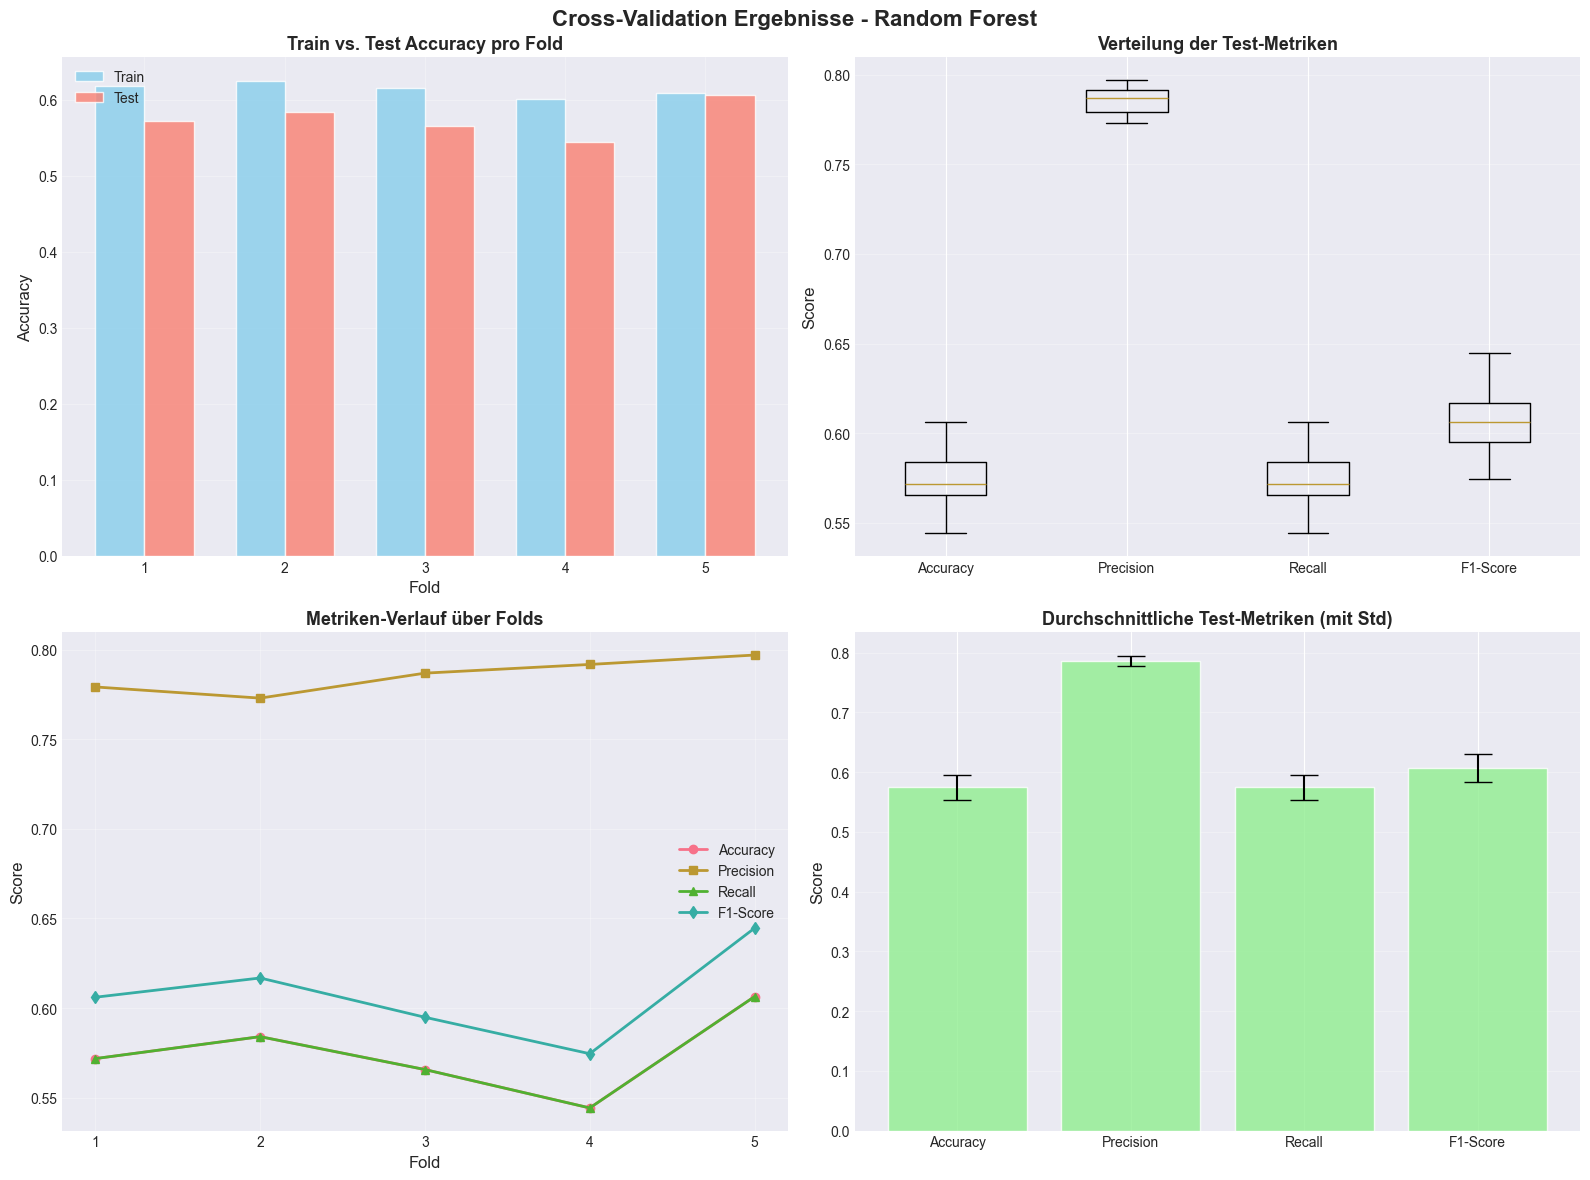

✓ Visualisierung gespeichert als 'figures/figure_cv_analysis.png'


In [54]:
# Visualize Cross-Validation Results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cross-Validation Ergebnisse - Random Forest', fontsize=16, fontweight='bold')

# 1. Train vs Test Accuracy per Fold
ax1 = axes[0, 0]
x = cv_results_df['Fold']
width = 0.35
ax1.bar(x - width/2, cv_results_df['Train Accuracy'], width, label='Train', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, cv_results_df['Test Accuracy'], width, label='Test', alpha=0.8, color='salmon')
ax1.set_xlabel('Fold', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Train vs. Test Accuracy pro Fold', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(x)

# 2. Box Plot of all metrics
ax2 = axes[0, 1]
metrics_data = [cv_results['test_accuracy'],
                cv_results['test_precision_weighted'],
                cv_results['test_recall_weighted'],
                cv_results['test_f1_weighted']]
ax2.boxplot(metrics_data, labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Verteilung der Test-Metriken', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Line plot showing progression across folds
ax3 = axes[1, 0]
ax3.plot(cv_results_df['Fold'], cv_results_df['Test Accuracy'], marker='o', label='Accuracy', linewidth=2)
ax3.plot(cv_results_df['Fold'], cv_results_df['Test Precision'], marker='s', label='Precision', linewidth=2)
ax3.plot(cv_results_df['Fold'], cv_results_df['Test Recall'], marker='^', label='Recall', linewidth=2)
ax3.plot(cv_results_df['Fold'], cv_results_df['Test F1-Score'], marker='d', label='F1-Score', linewidth=2)
ax3.set_xlabel('Fold', fontsize=12)
ax3.set_ylabel('Score', fontsize=12)
ax3.set_title('Metriken-Verlauf über Folds', fontsize=13, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(cv_results_df['Fold'])

# 4. Summary Bar Chart
ax4 = axes[1, 1]
summary_data = summary_stats[summary_stats['Metrik'].str.contains('Test')]
metrics_names = [m.replace('Test ', '') for m in summary_data['Metrik']]
means = summary_data['Mittelwert'].values
stds = summary_data['Std. Abweichung'].values
x_pos = np.arange(len(metrics_names))
ax4.bar(x_pos, means, yerr=stds, align='center', alpha=0.8, ecolor='black', capsize=10, color='lightgreen')
ax4.set_ylabel('Score', fontsize=12)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(metrics_names, rotation=0)
ax4.set_title('Durchschnittliche Test-Metriken (mit Std)', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/figure_cv_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualisierung gespeichert als 'figures/figure_cv_analysis.png'")

### 5.3 Feature Importance Visualisation

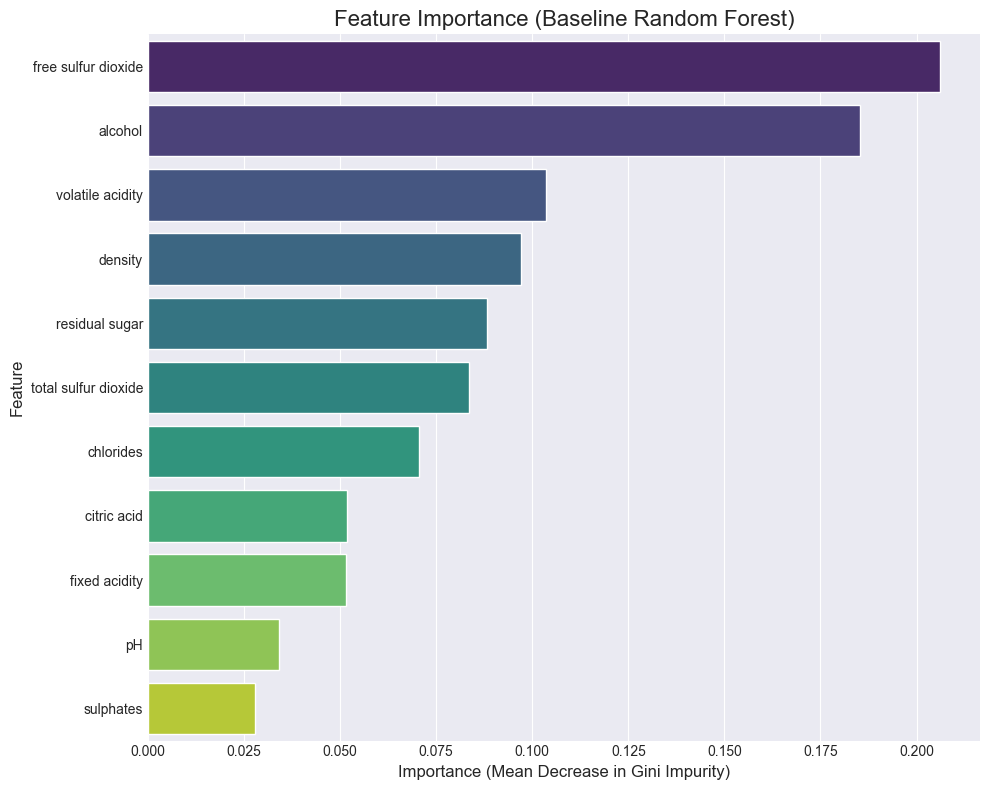


Top 11 Wichtigste Features:
                 Feature  Importance
5    free sulfur dioxide    0.206202
10               alcohol    0.185211
1       volatile acidity    0.103641
7                density    0.097049
3         residual sugar    0.088345
6   total sulfur dioxide    0.083525
4              chlorides    0.070570
2            citric acid    0.051711
0          fixed acidity    0.051651
8                     pH    0.034147
9              sulphates    0.027949


In [55]:
# 1. Feature Importance extrahieren
importances = baseline_model.named_steps['rf'].feature_importances_

# 2. Feature-Namen holen
feature_names = X_train.columns

# 3. In einem DataFrame für einfaches Plotten kombinieren
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 4. Nach Wichtigkeit sortieren
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 5. Visualisieren
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)

plt.title('Feature Importance (Baseline Random Forest)', fontsize=16)
plt.xlabel('Importance (Mean Decrease in Gini Impurity)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('figures/feature_importance_baselineRF.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 11 Wichtigste Features:")
print(feature_importance_df.head(11))

## 6. Feature Selection Methods <a id='feature-selection'></a>

In [56]:
feature_importance_results = {}

# 1. Spearman's Rank Correlation
ordinal_mapping = {'schlecht': 0, 'mittel': 1, 'gut': 2}
y_train_ordinal = y_train.map(ordinal_mapping)
spearman_scores = X_train_scaled.corrwith(y_train_ordinal, method='spearman').abs()
feature_importance_results['Spearman Correlation'] = spearman_scores

# 2. Mutual Information
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=RANDOM_STATE)
feature_importance_results['Mutual Information'] = pd.Series(mi_scores, index=X_train.columns)

# 3. ANOVA F-test
f_scores, _ = f_classif(X_train_scaled, y_train)
feature_importance_results['ANOVA F-Score'] = pd.Series(f_scores, index=X_train.columns)

# 4. Tree Importance
tree_importance = pd.Series(baseline_model.named_steps['rf'].feature_importances_, index=X_train.columns)
feature_importance_results['Tree Importance'] = tree_importance

# 5. Permutation Importance
perm_importance = permutation_importance(
    baseline_model, X_val_scaled, y_val,
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)
perm_scores = pd.Series(perm_importance.importances_mean, index=X_train.columns)
feature_importance_results['Permutation Importance'] = perm_scores

print("✓ Feature Selection Methods Complete (6 methods)")

✓ Feature Selection Methods Complete (6 methods)


In [57]:
# Compile and normalize
importance_df = pd.DataFrame(feature_importance_results)
importance_df_norm = importance_df.copy()

for col in importance_df_norm.columns:
    importance_df_norm[col] = (importance_df_norm[col] - importance_df_norm[col].min()) / \
                               (importance_df_norm[col].max() - importance_df_norm[col].min())

importance_df_norm['Average Score'] = importance_df_norm.mean(axis=1)
importance_df_norm['Rank'] = importance_df_norm['Average Score'].rank(ascending=False)
importance_df_norm = importance_df_norm.sort_values('Average Score', ascending=False)

print("\n" + "="*80)
print("TABLE 3: FEATURE IMPORTANCE RANKINGS")
print("="*80)
display(importance_df_norm.round(4))

importance_df_norm.to_csv('figures/table3_feature_importance_rankings.csv', sep=";")
print("\n✓ Saved to figures/table3_feature_importance_rankings.csv")


TABLE 3: FEATURE IMPORTANCE RANKINGS


,Spearman Correlation,Mutual Information,ANOVA F-Score,Tree Importance,Permutation Importance,Average Score,Rank
alcohol,1.0000,0.7242,1.0000,0.8822,1.0000,0.9213,1.0
density,0.8137,1.0000,0.5317,0.3876,0.0901,0.5646,2.0
free sulfur dioxide,0.0766,0.2928,0.1371,1.0000,0.2503,0.3514,3.0
chlorides,0.7457,0.2149,0.3831,0.2391,0.0626,0.3291,4.0
total sulfur dioxide,0.3613,0.3556,0.2259,0.3118,0.0075,0.2524,5.0
residual sugar,0.1294,0.3114,0.1335,0.3388,0.2641,0.2354,6.0
volatile acidity,0.2501,0.0000,0.1557,0.4246,0.0738,0.1809,7.0
fixed acidity,0.1399,0.0332,0.0379,0.1330,0.1051,0.0898,8.0
pH,0.2323,0.0475,0.0365,0.0348,0.0751,0.0852,9.0
citric acid,0.0000,0.2072,0.0000,0.1333,0.0000,0.0681,10.0



✓ Saved to figures/table3_feature_importance_rankings.csv


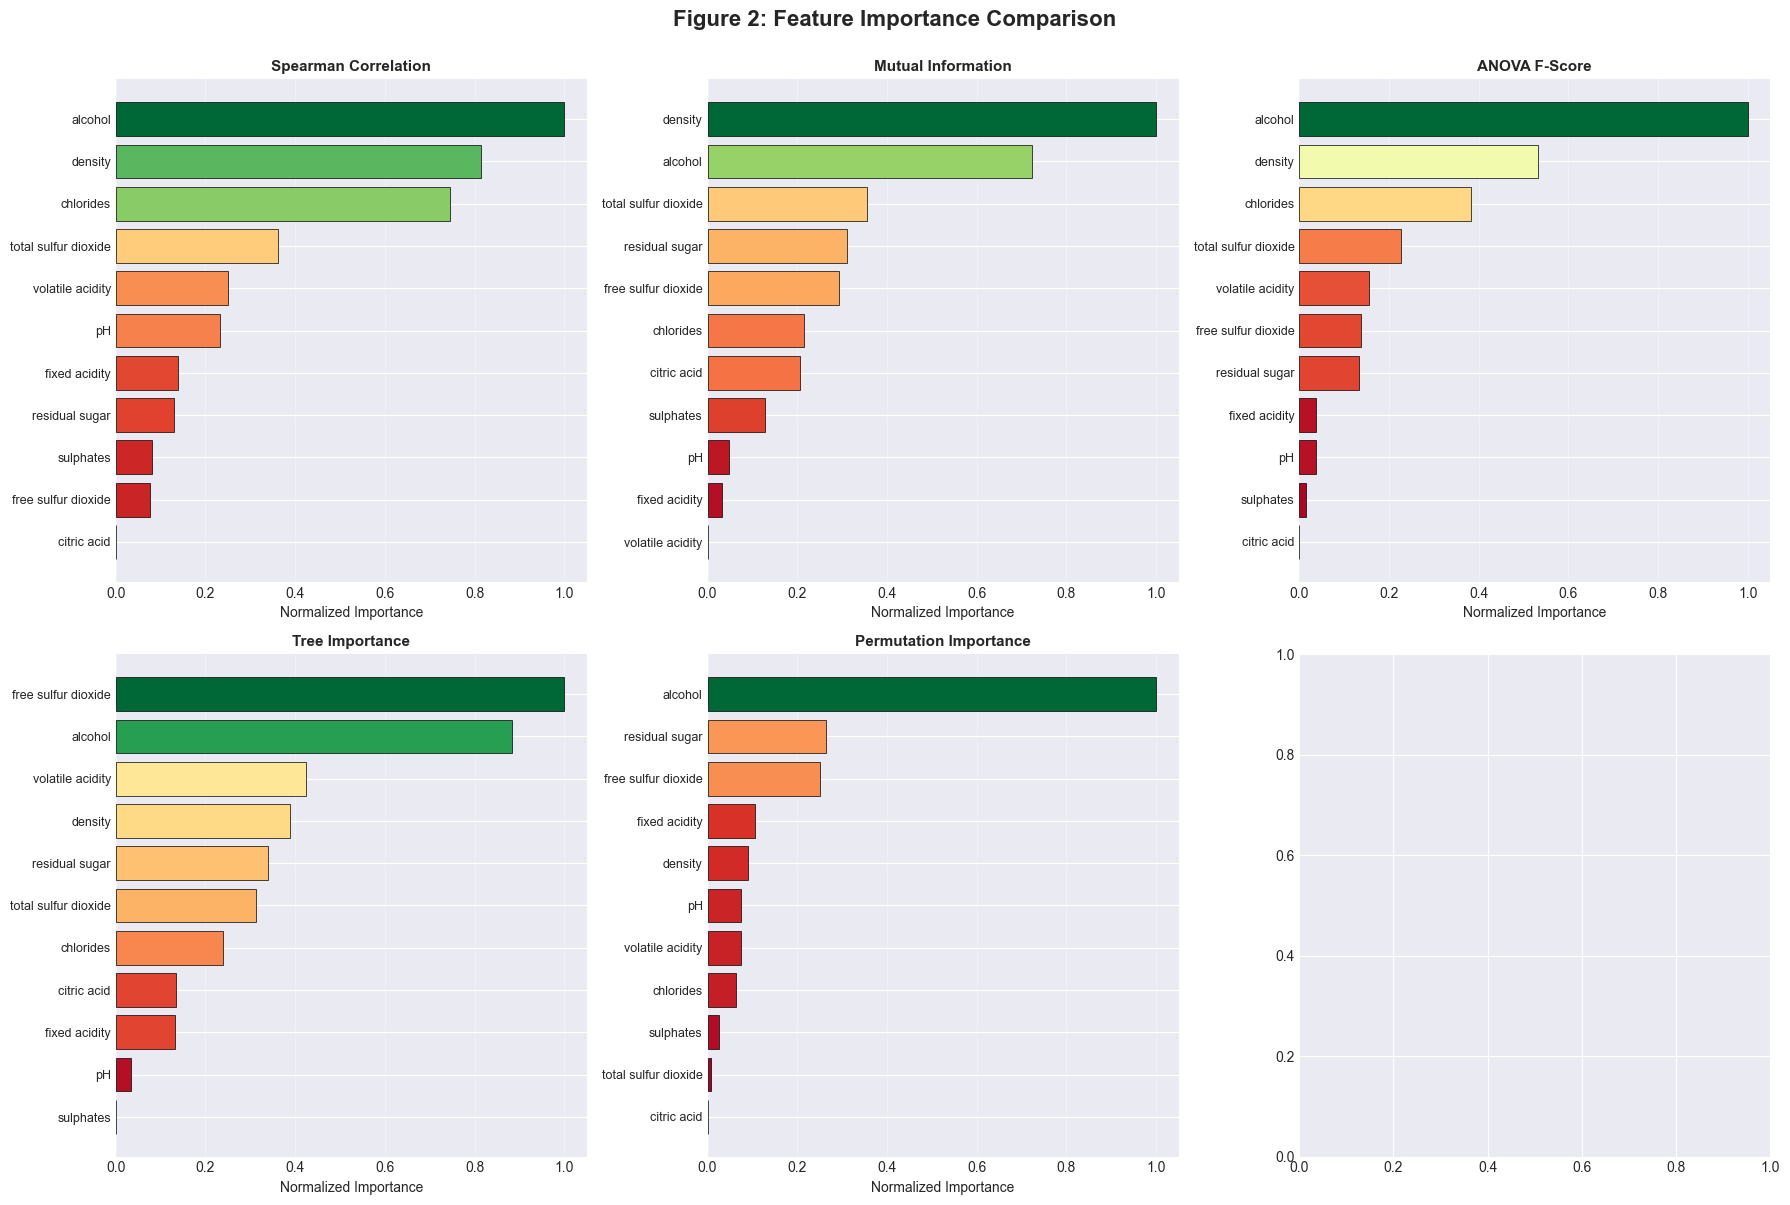

✓ Figure 2 saved


In [58]:
# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

methods = ['Spearman Correlation', 'Mutual Information', 'ANOVA F-Score',
           'Tree Importance', 'Permutation Importance']

for idx, method in enumerate(methods):
    data = importance_df_norm[method].sort_values(ascending=True)
    colors = plt.cm.RdYlGn(data / data.max())
    axes[idx].barh(range(len(data)), data.values, color=colors, edgecolor='black', linewidth=0.5)
    axes[idx].set_yticks(range(len(data)))
    axes[idx].set_yticklabels(data.index, fontsize=9)
    axes[idx].set_xlabel('Normalized Importance', fontsize=10)
    axes[idx].set_title(method, fontsize=11, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Figure 2: Feature Importance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('figures/figure2_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved")

## 7. Ablation Study <a id='ablation'></a>

### 7.1 Individual Feature Ablation

In [ ]:
ablation_results = []

print("Running Individual Feature Ablation (using CV)...\n")

# Dictionary to store CV scores for each feature removal
cv_scores_dict = {}

baseline_cv_f1_mean = baseline_metrics['CV Mean F1']

for feature in X_train.columns:
    features_subset = [f for f in X_train.columns if f != feature]
    X_train_ablated = X_train_scaled[features_subset]

    # Cross-Validation
    cv_scores = cross_val_score(baseline_model, X_train_ablated, y_train, cv=CV_FOLDS, scoring='f1_weighted')
    cv_scores_dict[feature] = cv_scores

    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    f1_drop = baseline_cv_f1_mean - cv_mean

    ablation_results.append({
        'Feature Removed': feature,
        'CV Mean F1': cv_mean,
        'CV Std': cv_std,
        'F1 Drop': f1_drop,
        'Drop %': f1_drop / baseline_cv_f1_mean * 100
    })

    print(f"  Removed '{feature}': CV Mean F1={cv_mean:.4f} (±{cv_std:.4f}), F1 Drop={f1_drop:+.4f}")

ablation_df = pd.DataFrame(ablation_results).sort_values('F1 Drop', ascending=False)

print("\n" + "="*80)
print("TABLE 4: INDIVIDUAL FEATURE ABLATION RESULTS")
print("="*80)
display(ablation_df)

ablation_df.to_csv('figures/table4_ablation_results.csv', index=False, sep=";")
print("\n✓ Saved to figures/table4_ablation_results.csv")

Running Individual Feature Ablation (using CV)...

  Removed 'fixed acidity': CV Mean F1=0.6032 (±0.0166), F1 Drop=+0.0042
  Removed 'volatile acidity': CV Mean F1=0.6144 (±0.0150), F1 Drop=-0.0070
  Removed 'citric acid': CV Mean F1=0.6020 (±0.0191), F1 Drop=+0.0054
  Removed 'residual sugar': CV Mean F1=0.6011 (±0.0207), F1 Drop=+0.0063
  Removed 'chlorides': CV Mean F1=0.5936 (±0.0187), F1 Drop=+0.0138
  Removed 'free sulfur dioxide': CV Mean F1=0.5851 (±0.0232), F1 Drop=+0.0223
  Removed 'total sulfur dioxide': CV Mean F1=0.5900 (±0.0233), F1 Drop=+0.0174
  Removed 'density': CV Mean F1=0.6111 (±0.0157), F1 Drop=-0.0037
  Removed 'pH': CV Mean F1=0.5991 (±0.0236), F1 Drop=+0.0083


In [31]:
print("\n" + "="*80)
print("T-TESTS: Individual Feature Ablation (F1-Score)")
print("="*80)

baseline_cv_scores_f1 = cv_scores_f1

print("\n1. Each Feature vs Baseline (All Features):")
print("-" * 60)

for feature in X_train.columns:
    t_stat, p_value = stats.ttest_rel(baseline_cv_scores_f1, cv_scores_dict[feature])
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  '{feature}' vs Baseline: t={t_stat:+.3f}, p={p_value:.4f} {significance}")

print("\n2. Features Pairwise Comparisons:")
print("-" * 60)

features_list = list(X_train.columns)
for i in range(len(features_list)):
    for j in range(i+1, len(features_list)):
        feat1, feat2 = features_list[i], features_list[j]
        t_stat, p_value = stats.ttest_rel(cv_scores_dict[feat1], cv_scores_dict[feat2])
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

        if p_value < 0.05: # Nur signifikante Unterschiede anzeigen
            print(f"  '{feat1}' vs '{feat2}': t={t_stat:+.3f}, p={p_value:.4f} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant")


T-TESTS: Individual Feature Ablation (F1-Score)

1. Each Feature vs Baseline (All Features):
------------------------------------------------------------
  'fixed_acidity' vs Baseline: t=-1.751, p=0.1549 ns
  'volatile_acidity' vs Baseline: t=-4.753, p=0.0090 **
  'citric_acid' vs Baseline: t=+0.604, p=0.5783 ns
  'residual_sugar' vs Baseline: t=-1.855, p=0.1372 ns
  'chlorides' vs Baseline: t=+0.087, p=0.9345 ns
  'free_sulfur_dioxide' vs Baseline: t=+3.650, p=0.0218 *
  'total_sulfur_dioxide' vs Baseline: t=+1.377, p=0.2406 ns
  'density' vs Baseline: t=-1.426, p=0.2270 ns
  'pH' vs Baseline: t=-0.476, p=0.6587 ns
  'sulphates' vs Baseline: t=-1.517, p=0.2038 ns
  'alcohol' vs Baseline: t=+5.196, p=0.0065 **

2. Features Pairwise Comparisons:
------------------------------------------------------------
  'fixed_acidity' vs 'free_sulfur_dioxide': t=+4.703, p=0.0093 **
  'fixed_acidity' vs 'alcohol': t=+3.593, p=0.0229 *
  'volatile_acidity' vs 'citric_acid': t=+3.835, p=0.0185 *
  'v

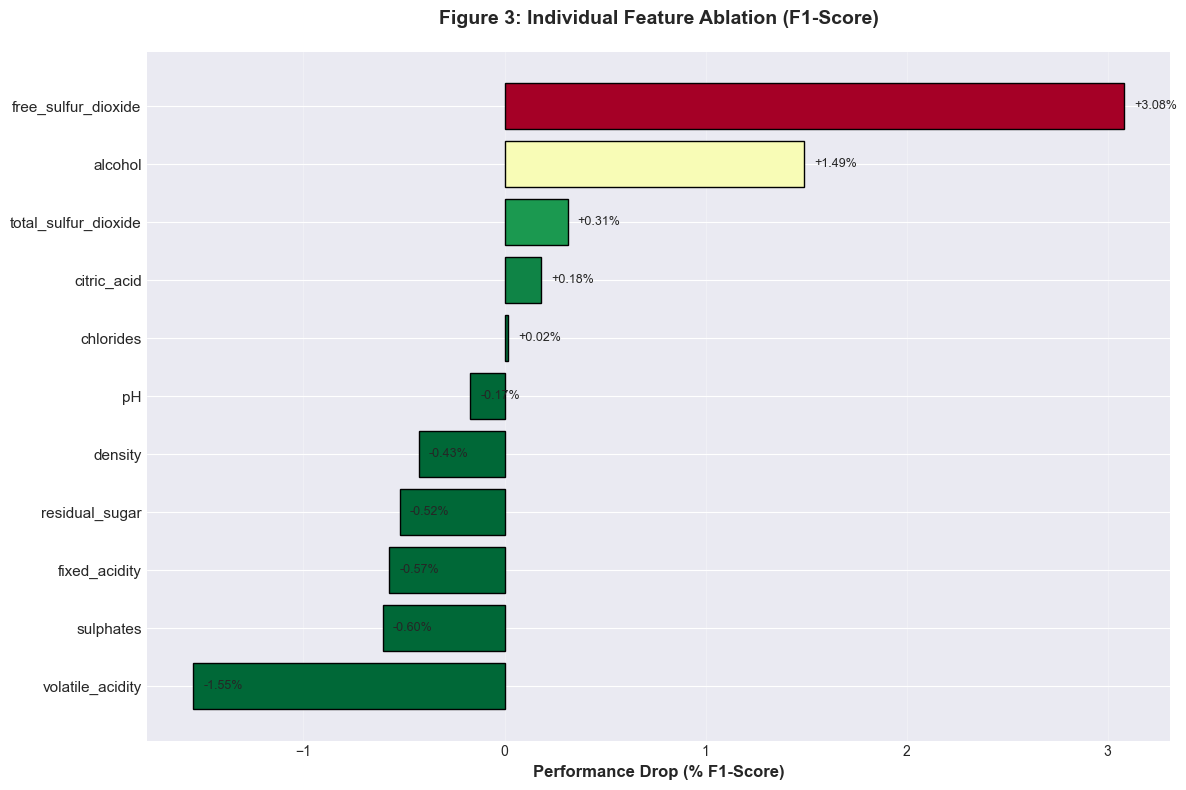

✓ Figure 3 saved (using F1-Score)


In [32]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 8))

plot_data = ablation_df.sort_values('F1 Drop', ascending=True)
colors = plt.cm.RdYlGn_r(plot_data['F1 Drop'] / plot_data['F1 Drop'].max())

# Plotte den F1 Drop
ax.barh(range(len(plot_data)), plot_data['F1 Drop'].values * 100,
        color=colors, edgecolor='black', linewidth=1)

ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['Feature Removed'], fontsize=11)

ax.set_xlabel('Performance Drop (% F1-Score)', fontsize=12, fontweight='bold')
ax.set_title('Figure 3: Individual Feature Ablation (F1-Score)', fontsize=14, fontweight='bold', pad=20)

ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(plot_data.iterrows()):
    value = row['F1 Drop'] * 100
    ax.text(value + 0.05, i, f"{value:+.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/figure3_individual_ablation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 3 saved (using F1-Score)")

### 7.2 Cumulative Feature Addition

In [33]:
feature_order = importance_df_norm['Average Score'].sort_values(ascending=False).index.tolist()
cumulative_results = []

print("Running Cumulative Feature Addition (using CV)...\n")

cv_scores_cumulative = {}

for i in range(1, len(feature_order) + 1):
    selected_features = feature_order[:i]
    X_train_subset = X_train_scaled[selected_features]

    cv_scores = cross_val_score(
        baseline_model,
        X_train_subset,
        y_train,
        cv=CV_FOLDS,
        scoring='f1_weighted'
    )

    cv_scores_cumulative[i] = cv_scores
    cv_mean = cv_scores.mean()

    cumulative_results.append({
        'Num Features': i,
        'CV Mean F1': cv_mean,
        'CV Std': cv_scores.std()
    })

    print(f"Top {i:2d}: CV Mean F1 = {cv_mean:.4f}")

cumulative_df = pd.DataFrame(cumulative_results)

Running Cumulative Feature Addition (using CV)...

Top  1: CV Mean F1 = 0.5781
Top  2: CV Mean F1 = 0.5718
Top  3: CV Mean F1 = 0.4863
Top  4: CV Mean F1 = 0.5911
Top  5: CV Mean F1 = 0.5899
Top  6: CV Mean F1 = 0.5907
Top  7: CV Mean F1 = 0.5934
Top  8: CV Mean F1 = 0.6029
Top  9: CV Mean F1 = 0.6032
Top 10: CV Mean F1 = 0.6058
Top 11: CV Mean F1 = 0.6118


In [34]:
print("\n" + "="*80)
print("T-TESTS: Cumulative Feature Addition")
print("="*80)

# Baseline = all features (k=11)
baseline_cv_scores_cumulative = cv_scores_cumulative[11]

print("\n1. Each K vs Baseline (K=11):")
print("-" * 60)

for k in range(1, 11):  # 1 to 10 (11 is baseline)
    t_stat, p_value = stats.ttest_rel(baseline_cv_scores_cumulative, cv_scores_cumulative[k])
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  K={k:2d} vs K=11: t={t_stat:+.3f}, p={p_value:.4f} {significance}")

print("\n2. Adjacent K Comparisons (K vs K+1):")
print("-" * 60)

for k in range(1, 11):
    t_stat, p_value = stats.ttest_rel(cv_scores_cumulative[k], cv_scores_cumulative[k+1])
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  K={k:2d} vs K={k+1:2d}: t={t_stat:+.3f}, p={p_value:.4f} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant")


T-TESTS: Cumulative Feature Addition

1. Each K vs Baseline (K=11):
------------------------------------------------------------
  K= 1 vs K=11: t=+1.298, p=0.2640 ns
  K= 2 vs K=11: t=+4.308, p=0.0126 *
  K= 3 vs K=11: t=+14.409, p=0.0001 ***
  K= 4 vs K=11: t=+2.463, p=0.0695 ns
  K= 5 vs K=11: t=+4.272, p=0.0129 *
  K= 6 vs K=11: t=+4.559, p=0.0103 *
  K= 7 vs K=11: t=+2.485, p=0.0679 ns
  K= 8 vs K=11: t=+1.191, p=0.2996 ns
  K= 9 vs K=11: t=+1.297, p=0.2643 ns
  K=10 vs K=11: t=+0.976, p=0.3845 ns

2. Adjacent K Comparisons (K vs K+1):
------------------------------------------------------------
  K= 1 vs K= 2: t=+0.238, p=0.8233 ns
  K= 2 vs K= 3: t=+15.056, p=0.0001 ***
  K= 3 vs K= 4: t=-10.106, p=0.0005 ***
  K= 4 vs K= 5: t=+0.143, p=0.8932 ns
  K= 5 vs K= 6: t=-1.024, p=0.3636 ns
  K= 6 vs K= 7: t=-0.671, p=0.5391 ns
  K= 7 vs K= 8: t=-2.389, p=0.0752 ns
  K= 8 vs K= 9: t=-0.076, p=0.9429 ns
  K= 9 vs K=10: t=-0.891, p=0.4235 ns
  K=10 vs K=11: t=-0.976, p=0.3845 ns

Signif

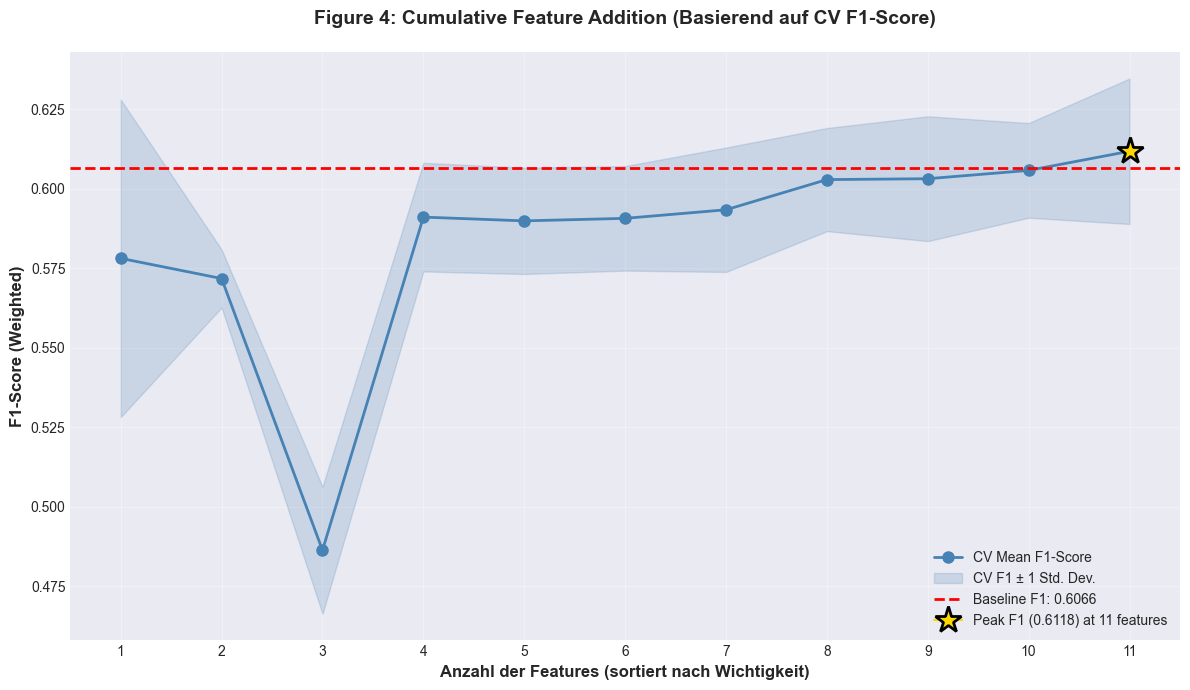

✓ Figure 4 (aktualisiert auf F1-Score) gespeichert.


In [35]:
baseline_f1_score = baseline_metrics['CV Mean F1']

# --- Visualisierung ---
fig, ax = plt.subplots(figsize=(12, 7))

# 1. Plotte die CV Mean F1-Linie
ax.plot(cumulative_df['Num Features'], cumulative_df['CV Mean F1'],
        marker='o', linewidth=2, markersize=8, color='steelblue', label='CV Mean F1-Score')

# 2. Plotte den "Fehlerbalken" (Standardabweichung)
ax.fill_between(cumulative_df['Num Features'],
                cumulative_df['CV Mean F1'] - cumulative_df['CV Std'],
                cumulative_df['CV Mean F1'] + cumulative_df['CV Std'],
                alpha=0.2, color='steelblue', label='CV F1 ± 1 Std. Dev.')

# 3. Plotte die Baseline F1-Linie
ax.axhline(y=baseline_f1_score, color='red', linestyle='--',
           linewidth=2, label=f"Baseline F1: {baseline_f1_score:.4f}")

# 4. Finde und markiere den Peak F1-Score
max_idx = cumulative_df['CV Mean F1'].idxmax()
peak_features = cumulative_df.loc[max_idx, 'Num Features']
peak_f1 = cumulative_df.loc[max_idx, 'CV Mean F1']

ax.plot(peak_features, peak_f1,
        marker='*', markersize=20, color='gold',
        markeredgecolor='black', markeredgewidth=2,
        label=f"Peak F1 ({peak_f1:.4f}) at {peak_features} features")

# --- Beschriftungen und Layout ---
ax.set_xlabel('Anzahl der Features (sortiert nach Wichtigkeit)', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score (Weighted)', fontsize=12, fontweight='bold')
ax.set_title('Figure 4: Cumulative Feature Addition (Basierend auf CV F1-Score)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, len(feature_order) + 1)) # Stellt sicher, dass jeder Punkt auf der X-Achse markiert ist

plt.tight_layout()
plt.savefig('figures/figure4_cumulative_addition.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 4 (aktualisiert auf F1-Score) gespeichert.")

### 7.3 Feature Group Ablation

In [36]:
print("Running Feature Group Ablation (using CV F1-Score)...\\n")

feature_groups = {
    'acidity': ['fixed acidity', 'volatile acidity', 'citric acid', 'pH'],
    'sulfur': ['free sulfur dioxide', 'total sulfur dioxide', 'sulphates'],
    'content': ['residual sugar', 'chlorides', 'alcohol'],
    'physical': ['density']
}

baseline_cv_f1_score = baseline_metrics['CV Mean F1']
print(f"Baseline CV F1-Score (Alle Features): {baseline_cv_f1_score:.4f}\\n")

group_ablation_results = []
cv_scores_groups = {}

for group_name, group_features in feature_groups.items():
    X_train_ablated = X_train_scaled.drop(columns=group_features)

    # CV mit f1_weighted
    scores = cross_val_score(baseline_model, X_train_ablated, y_train, cv=CV_FOLDS, scoring='f1_weighted')
    cv_scores_groups[group_name] = scores

    current_score = scores.mean()

    # Vergleiche F1 mit F1
    performance_drop = baseline_cv_f1_score - current_score

    group_ablation_results.append({
        'Group Removed': group_name,
        'Num Features Removed': len(group_features),
        'CV Mean F1 (Ablated)': current_score,
        'CV Std': scores.std(),
        'F1 Drop': performance_drop
    })

    print(f"  Removed '{group_name}' ({len(group_features)} features): CV F1={current_score:.4f} (±{scores.std():.4f}), F1 Drop={performance_drop:+.4f}")

group_ablation_df = pd.DataFrame(group_ablation_results).sort_values('F1 Drop', ascending=False)

print("\n" + "="*80)
print("TABLE 6: FEATURE GROUP ABLATION RESULTS (F1-Score)")
print("="*80)
display(group_ablation_df)

group_ablation_df.to_csv('figures/table6_group_ablation_results.csv', index=False, sep=";")
print("\n✓ Saved to figures/table6_group_ablation_results.csv")

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
plot_data_group = group_ablation_df.sort_values('F1 Drop', ascending=True)
colors = plt.cm.viridis_r(plot_data_group['F1 Drop'] / plot_data_group['F1 Drop'].max())

ax.barh(plot_data_group['Group Removed'], plot_data_group['F1 Drop'] * 100,
        color=colors, edgecolor='black', linewidth=1)
ax.set_xlabel('Performance Drop (% F1-Score)', fontsize=12)
ax.set_title('Figure 6: Feature Group Ablation (F1-Score)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(plot_data_group.iterrows()):
    value = row['F1 Drop'] * 100
    ax.text(value + 0.01, i, f"{value:+.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/figure6_group_ablation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure 6 saved")

Running Feature Group Ablation (using CV F1-Score)...\n
Baseline CV F1-Score (Alle Features): 0.6066\n


KeyError: "['fixed acidity', 'volatile acidity', 'citric acid'] not found in axis"

In [361]:
print("\n" + "="*80)
print("T-TESTS: Feature Group Ablation (F1-Score)")
print("="*80)

baseline_cv_scores_groups = cv_scores_f1

print("\n1. Each Group vs Baseline:")
print("-" * 60)

for group_name in feature_groups.keys():
    t_stat, p_value = stats.ttest_rel(baseline_cv_scores_groups, cv_scores_groups[group_name])
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  '{group_name}' vs Baseline: t={t_stat:+.3f}, p={p_value:.4f} {significance}")

print("\n2. Groups Pairwise Comparisons:")
print("-" * 60)

groups_list = list(feature_groups.keys())
for i in range(len(groups_list)):
    for j in range(i+1, len(groups_list)):
        group1, group2 = groups_list[i], groups_list[j]
        t_stat, p_value = stats.ttest_rel(cv_scores_groups[group1], cv_scores_groups[group2])
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"  '{group1}' vs '{group2}': t={t_stat:+.3f}, p={p_value:.4f} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant")


T-TESTS: Feature Group Ablation (F1-Score)

1. Each Group vs Baseline:
------------------------------------------------------------
  'acidity' vs Baseline: t=+0.774, p=0.4819 ns
  'sulfur' vs Baseline: t=+6.402, p=0.0031 **
  'content' vs Baseline: t=+6.612, p=0.0027 **
  'physical' vs Baseline: t=-0.500, p=0.6433 ns

2. Groups Pairwise Comparisons:
------------------------------------------------------------
  'acidity' vs 'sulfur': t=+5.117, p=0.0069 **
  'acidity' vs 'content': t=+7.435, p=0.0017 **
  'acidity' vs 'physical': t=-2.409, p=0.0736 ns
  'sulfur' vs 'content': t=+0.505, p=0.6400 ns
  'sulfur' vs 'physical': t=-5.562, p=0.0051 **
  'content' vs 'physical': t=-11.102, p=0.0004 ***

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant


### 7.4 Top-K Feature Selection

In [362]:
k_values = [3, 5, 7, 9, 11]
topk_results = []

print("Testing Top-K Feature Selection (using CV F1-Score)...\n")

# Dictionary to store CV scores for each k
cv_scores_topk = {}

baseline_f1_mean = baseline_metrics['CV Mean F1']

for k in k_values:
    top_features = feature_order[:k]
    X_train_k = X_train_scaled[top_features]

    cv_scores = cross_val_score(
        baseline_model,
        X_train_k,
        y_train,
        cv=CV_FOLDS,
        scoring='f1_weighted'
    )
    cv_scores_topk[k] = cv_scores
    cv_mean_f1 = cv_scores.mean()

    # Berechne Metriken basierend auf F1
    complexity_reduction = (1 - k / len(feature_order)) * 100
    performance_retention = (cv_mean_f1 / baseline_f1_mean) * 100

    topk_results.append({
        'K': k,
        'CV Mean F1': cv_mean_f1,
        'CV Std': cv_scores.std(),
        'Complexity Reduction %': complexity_reduction,
        'Performance Retention %': performance_retention
    })

    print(f"Top-{k}: CV Mean F1={cv_mean_f1:.4f}, Retention={performance_retention:.1f}%")

topk_df = pd.DataFrame(topk_results)

print("\n" + "="*80)
print("TABLE 5: TOP-K PERFORMANCE (F1-Score)")
print("="*80)
display(topk_df)

topk_df.to_csv('figures/table5_topk_performance.csv', index=False, sep=";")
print("\n✓ Saved to figures/table5_topk_performance.csv")

Testing Top-K Feature Selection (using CV F1-Score)...

Top-3: CV Mean F1=0.5903, Retention=97.2%
Top-5: CV Mean F1=0.6024, Retention=99.2%
Top-7: CV Mean F1=0.6088, Retention=100.2%
Top-9: CV Mean F1=0.6007, Retention=98.9%
Top-11: CV Mean F1=0.5988, Retention=98.6%

TABLE 5: TOP-K PERFORMANCE (F1-Score)


,K,CV Mean F1,CV Std,Complexity Reduction %,Performance Retention %
0,3,0.590256,0.026182,72.727273,97.177167
1,5,0.602366,0.011590,54.545455,99.170920
2,7,0.608776,0.019953,36.363636,100.226221
3,9,0.600718,0.023095,18.181818,98.899637
4,11,0.598797,0.017403,0.000000,98.583328



✓ Saved to figures/table5_topk_performance.csv


In [363]:
print("\n" + "="*80)
print("T-TESTS: Top-K Feature Selection")
print("="*80)

# Baseline = K=11 (all features)
baseline_cv_scores_topk = cv_scores_topk[11]

print("\n1. Each K vs Baseline (K=11):")
print("-" * 60)

for k in [3, 5, 7, 9]:
    t_stat, p_value = stats.ttest_rel(baseline_cv_scores_topk, cv_scores_topk[k])
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  K={k:2d} vs K=11: t={t_stat:+.3f}, p={p_value:.4f} {significance}")

print("\n2. K Values Pairwise Comparisons:")
print("-" * 60)

k_list = [3, 5, 7, 9, 11]
for i in range(len(k_list)):
    for j in range(i+1, len(k_list)):
        k1, k2 = k_list[i], k_list[j]
        t_stat, p_value = stats.ttest_rel(cv_scores_topk[k1], cv_scores_topk[k2])
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"  K={k1:2d} vs K={k2:2d}: t={t_stat:+.3f}, p={p_value:.4f} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant")


T-TESTS: Top-K Feature Selection

1. Each K vs Baseline (K=11):
------------------------------------------------------------
  K= 3 vs K=11: t=+1.088, p=0.3376 ns
  K= 5 vs K=11: t=-0.812, p=0.4623 ns
  K= 7 vs K=11: t=-3.922, p=0.0172 *
  K= 9 vs K=11: t=-0.378, p=0.7245 ns

2. K Values Pairwise Comparisons:
------------------------------------------------------------
  K= 3 vs K= 5: t=-1.435, p=0.2247 ns
  K= 3 vs K= 7: t=-3.364, p=0.0282 *
  K= 3 vs K= 9: t=-1.169, p=0.3074 ns
  K= 3 vs K=11: t=-1.088, p=0.3376 ns
  K= 5 vs K= 7: t=-1.238, p=0.2835 ns
  K= 5 vs K= 9: t=+0.235, p=0.8255 ns
  K= 5 vs K=11: t=+0.812, p=0.4623 ns
  K= 7 vs K= 9: t=+1.658, p=0.1727 ns
  K= 7 vs K=11: t=+3.922, p=0.0172 *
  K= 9 vs K=11: t=+0.378, p=0.7245 ns

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant


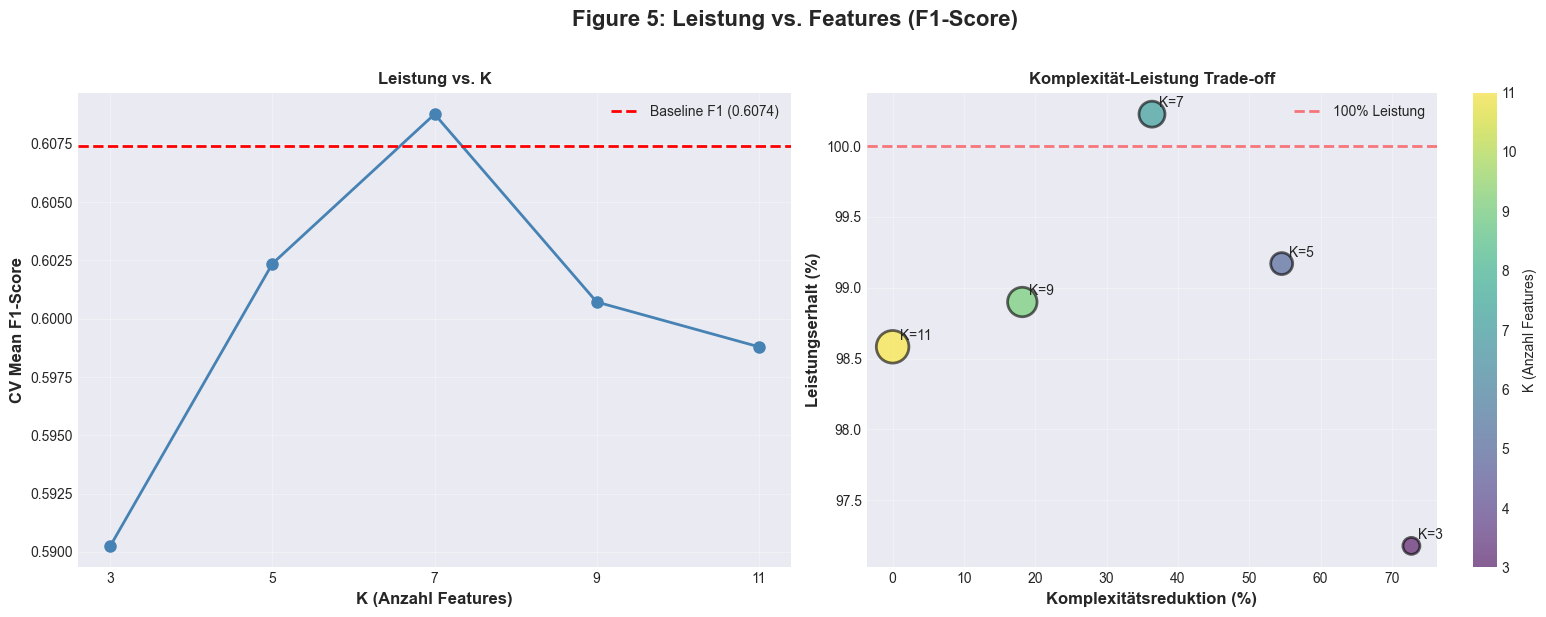

✓ Figure 5 (aktualisiert auf F1-Score) gespeichert.


In [364]:
baseline_f1_mean = baseline_metrics['CV Mean F1']

# --- Visualisierung ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: CV Mean F1 vs. K ---
axes[0].plot(topk_df['K'], topk_df['CV Mean F1'],
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axhline(y=baseline_f1_mean, color='red', linestyle='--', linewidth=2, label=f'Baseline F1 ({baseline_f1_mean:.4f})')
axes[0].set_xlabel('K (Anzahl Features)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('CV Mean F1-Score', fontsize=12, fontweight='bold')
axes[0].set_title('Leistung vs. K', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(topk_df['K'])
axes[0].legend()

# --- Plot 2: Complexity-Performance Trade-off ---
scatter = axes[1].scatter(topk_df['Complexity Reduction %'],
                          topk_df['Performance Retention %'],
                          s=topk_df['K']*50, alpha=0.6, c=topk_df['K'],
                          cmap='viridis', edgecolors='black', linewidth=2)

for _, row in topk_df.iterrows():
    axes[1].annotate(f"K={int(row['K'])}",
                     xy=(row['Complexity Reduction %'], row['Performance Retention %']),
                     xytext=(5, 5), textcoords='offset points')

axes[1].axhline(y=100, color='red', linestyle='--', linewidth=2, alpha=0.5, label='100% Leistung')
axes[1].set_xlabel('Komplexitätsreduktion (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Leistungserhalt (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Komplexität-Leistung Trade-off', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# --- Titel und Speichern ---
plt.colorbar(scatter, ax=axes[1], label='K (Anzahl Features)')
plt.suptitle('Figure 5: Leistung vs. Features (F1-Score)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/figure5_performance_vs_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 5 (aktualisiert auf F1-Score) gespeichert.")

### 7.4 Final Test Set Evaluation

In [365]:
print("="*80)
print("FINAL TEST SET EVALUATION (Unbiased F1-Score)")
print("="*80)

# 1. Finde das optimale K basierend auf dem CV Mean F1-Score
optimal_f1_idx = cumulative_df['CV Mean F1'].idxmax()

optimal_k = int(cumulative_df.loc[optimal_f1_idx, 'Num Features'])
optimal_features = feature_order[:optimal_k]
top5_features = feature_order[:5]

print(f"\nOptimal: {optimal_k} features - {', '.join(optimal_features)}\n")

test_evaluations = []
cv_scores_final = {}

baseline_test_f1 = baseline_metrics['Test F1']

# --- 1. Baseline (all features) ---
cv_scores_final['all'] = cross_val_score(baseline_model, X_train_scaled, y_train, cv=CV_FOLDS, scoring='f1_weighted')

test_evaluations.append({
    'Configuration': 'All Features',
    'Num Features': 11,
    'Test F1': baseline_test_f1,
    'CV Mean F1': cv_scores_final['all'].mean(),
    'CV Std': cv_scores_final['all'].std()
})

# --- 2. Optimal subset ---
# (Klone Pipeline, um sie neu zu trainieren)
model_optimal_pipe = clone(baseline_model)
X_train_opt = X_train_scaled[optimal_features]
X_test_opt = X_test_scaled[optimal_features]

cv_scores_final['optimal'] = cross_val_score(model_optimal_pipe, X_train_opt, y_train, cv=CV_FOLDS, scoring='f1_weighted')
model_optimal_pipe.fit(X_train_opt, y_train) # Trainiere die Pipeline auf den Subset-Daten
y_test_pred_opt = model_optimal_pipe.predict(X_test_opt)

test_evaluations.append({
    'Configuration': f'Optimal ({optimal_k})',
    'Num Features': optimal_k,
    'Test F1': f1_score(y_test, y_test_pred_opt, average='weighted'),
    'CV Mean F1': cv_scores_final['optimal'].mean(),
    'CV Std': cv_scores_final['optimal'].std()
})

# --- 3. Top-5 ---
# (Klone die Pipeline erneut)
model_top5_pipe = clone(baseline_model)
X_train_top5 = X_train_scaled[top5_features]
X_test_top5 = X_test_scaled[top5_features]

cv_scores_final['top5'] = cross_val_score(model_top5_pipe, X_train_top5, y_train, cv=CV_FOLDS, scoring='f1_weighted')
model_top5_pipe.fit(X_train_top5, y_train)
y_test_pred_5 = model_top5_pipe.predict(X_test_top5)

test_evaluations.append({
    'Configuration': 'Top-5',
    'Num Features': 5,
    'Test F1': f1_score(y_test, y_test_pred_5, average='weighted'),
    'CV Mean F1': cv_scores_final['top5'].mean(),
    'CV Std': cv_scores_final['top5'].std()
})

# --- Ergebnisse ---
test_results_df = pd.DataFrame(test_evaluations)
display(test_results_df)

test_results_df.to_csv('figures/final_test_evaluation.csv', index=False, sep=";")
print("\n✓ Saved to figures/final_test_evaluation.csv")

FINAL TEST SET EVALUATION (Unbiased F1-Score)

Optimal: 1 features - alcohol



,Configuration,Num Features,Test F1,CV Mean F1,CV Std
0,All Features,11,0.619248,0.607402,0.023275
1,Optimal (1),1,0.626149,0.611125,0.026654
2,Top-5,5,0.604862,0.602366,0.011590



✓ Saved to figures/final_test_evaluation.csv


In [366]:
print("\n" + "="*80)
print("T-TESTS: Final Test Set Configurations")
print("="*80)

print("\n1. All Features vs Optimal:")
print("-" * 60)
t_stat, p_value = stats.ttest_rel(cv_scores_final['all'], cv_scores_final['optimal'])
significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
print(f"  t={t_stat:+.3f}, p={p_value:.4f} {significance}")

print("\n2. All Features vs Top-5:")
print("-" * 60)
t_stat, p_value = stats.ttest_rel(cv_scores_final['all'], cv_scores_final['top5'])
significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
print(f"  t={t_stat:+.3f}, p={p_value:.4f} {significance}")

print("\n3. Optimal vs Top-5:")
print("-" * 60)
t_stat, p_value = stats.ttest_rel(cv_scores_final['optimal'], cv_scores_final['top5'])
significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
print(f"  t={t_stat:+.3f}, p={p_value:.4f} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant")


T-TESTS: Final Test Set Configurations

1. All Features vs Optimal:
------------------------------------------------------------
  t=-0.182, p=0.8644 ns

2. All Features vs Top-5:
------------------------------------------------------------
  t=+0.715, p=0.5139 ns

3. Optimal vs Top-5:
------------------------------------------------------------
  t=+0.585, p=0.5902 ns

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant
